## Домашнее задание №7

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt
from IPython.display import clear_output

### Задача №1:
Обратимся к классической задаче распознавания рукописных цифр. Мы будем работать с набором данных [MNIST](http://yann.lecun.com/exdb/mnist/). В данном задании воспользуемся всем датасетом целиком.

__Ваша основная задача: реализовать весь пайплан обучения модели и добиться качества $\geq 92\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбуку первого занятия.

Настоятельно рекомендуем написать код "с нуля", лишь поглядывая на готовые примеры, а не просто "скопировать-вставить". Это поможет вам в дальнейшем.

Text(0.5, 1.0, 'Image label: 1')

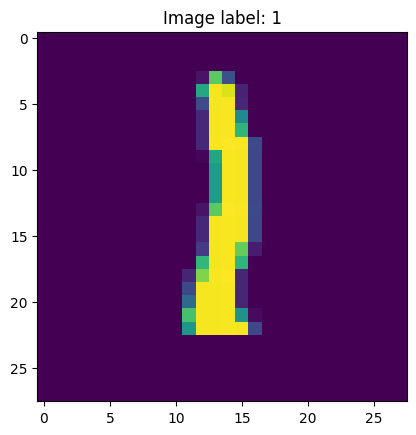

In [2]:
# do not change the code in the block below
# __________start of block__________

train_mnist_data = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist_data = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)


train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 92% accuracy.

*Комментарий: для этого достаточно линейных слоев и функций активации.*

__Внимание, ваша модель должна быть представлена именно переменной `model`.__

In [3]:
import os
from torchvision import datasets, transforms

In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class Model(nn.Module):
    def __init__(self, in_features, hidden_units, out_features):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(in_channels=in_features, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*27*27, out_features=out_features)
        )
    #     self.flatten = nn.Flatten()
    #     self.linear_relu_stack = nn.Sequential(
    #         nn.Linear(28*28, 512),
    #         nn.ReLU(),
    #         nn.Linear(512, 512),
    #         nn.ReLU(),
    #         nn.Linear(512, 10)
    #     )

    # def forward(self, x):
    #     x = self.flatten(x)
    #     logits = self.linear_relu_stack(x)
    #     return logits
    def forward(self, X):
        return self.stack(X)

model = Model(1, 8, 10).to(device)
print(model)

Using cpu device
Model(
  (stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=5832, out_features=10, bias=True)
  )
)


input_image = torch.rand(3,25,25)
print(input_image.size())

In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [7]:
@torch.inference_mode()
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [8]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_data_loader, model, loss_fn, optimizer)
    test(test_data_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.293745  [   32/60000]
loss: 2.250609  [ 3232/60000]
loss: 2.180439  [ 6432/60000]
loss: 2.049407  [ 9632/60000]
loss: 1.790216  [12832/60000]
loss: 1.445991  [16032/60000]
loss: 1.224230  [19232/60000]
loss: 0.861920  [22432/60000]
loss: 0.629750  [25632/60000]
loss: 0.502261  [28832/60000]
loss: 0.441359  [32032/60000]
loss: 0.403289  [35232/60000]
loss: 0.564721  [38432/60000]
loss: 0.424243  [41632/60000]
loss: 0.431653  [44832/60000]
loss: 0.404983  [48032/60000]
loss: 0.412143  [51232/60000]
loss: 0.432565  [54432/60000]
loss: 0.304141  [57632/60000]
Test Error: 
 Accuracy: 89.8%, Avg loss: 0.352226 

Epoch 2
-------------------------------
loss: 0.276413  [   32/60000]
loss: 0.191639  [ 3232/60000]
loss: 0.288340  [ 6432/60000]
loss: 0.612043  [ 9632/60000]
loss: 0.314453  [12832/60000]
loss: 0.255576  [16032/60000]
loss: 0.291981  [19232/60000]
loss: 0.268851  [22432/60000]
loss: 0.115360  [25632/60000]
loss: 0.131745  [28832/60000

In [9]:
# Creating model instance

model = model.to(device) # your code here

Локальные тесты для проверки вашей модели доступны ниже:

In [26]:
# do not change the code in the block below
# __________start of block__________
assert model is not None, 'Please, use `model` variable to store your model'

try:
    x = random_batch[0]#.reshape(-1, 784)
    y = random_batch[1]

    # compute outputs given inputs, both are variables
    y_predicted = model(x)
except Exception as e:
    print('Something is wrong with the model')
    raise e


assert y_predicted.shape[-1] == 10, 'Model should predict 10 logits/probas'

print('Everything seems fine!')
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Рекомендуем поработать с различными оптимизаторами.

In [40]:
# your code here
# model has one hyperparameter - quantity of hidden units
epochs = 1
for hp_hidden_units in [7, 8, 9, 10]:
    model_test = Model(1, hp_hidden_units, 10).to(device)
    for lr in [1e-3, 1e-2, 1e-1]:
        optimizer_rmsprob = torch.optim.RMSprop(model_test.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train(train_data_loader, model_test, loss_fn, optimizer_rmsprob)
            test(test_data_loader, model_test, loss_fn)
            print(f'hidden_unites: {hp_hidden_units}, lr: {lr}')
        print("Done!")

Epoch 1
-------------------------------
loss: 2.294163  [   32/60000]
loss: 0.521802  [ 3232/60000]
loss: 0.156765  [ 6432/60000]
loss: 0.062194  [ 9632/60000]
loss: 0.110805  [12832/60000]
loss: 0.124759  [16032/60000]
loss: 0.185440  [19232/60000]
loss: 0.081034  [22432/60000]
loss: 0.202171  [25632/60000]
loss: 0.606714  [28832/60000]
loss: 0.066471  [32032/60000]
loss: 0.066596  [35232/60000]
loss: 0.129204  [38432/60000]
loss: 0.060008  [41632/60000]
loss: 0.104733  [44832/60000]
loss: 0.042695  [48032/60000]
loss: 0.063978  [51232/60000]
loss: 0.046363  [54432/60000]
loss: 0.115506  [57632/60000]
Test Error: 
 Accuracy: 97.9%, Avg loss: 0.065025 

hidden_unites: 7, lr: 0.001
Done!
Epoch 1
-------------------------------
loss: 0.034467  [   32/60000]
loss: 0.331275  [ 3232/60000]
loss: 0.281680  [ 6432/60000]
loss: 0.191127  [ 9632/60000]
loss: 0.094878  [12832/60000]
loss: 0.094710  [16032/60000]
loss: 0.040435  [19232/60000]
loss: 0.125166  [22432/60000]
loss: 0.101250  [25632/6

In [ ]:
# best:
# Accuracy: 98.1%, Avg loss: 0.058935
# hidden_unites: 9, lr: 0.001

In [41]:
epochs = 1
for hp_hidden_units in [7, 8, 9, 10]:
    model_test = Model(1, hp_hidden_units, 10).to(device)
    for lr in [1e-3, 1e-2]:
        optimizer_adam = torch.optim.Adam(model_test.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train(train_data_loader, model_test, loss_fn, optimizer_adam)
            test(test_data_loader, model_test, loss_fn)
            print(f'hidden_unites: {hp_hidden_units}, lr: {lr}')
        print("Done!")

Epoch 1
-------------------------------
loss: 2.300851  [   32/60000]
loss: 0.370973  [ 3232/60000]
loss: 0.775004  [ 6432/60000]
loss: 0.214979  [ 9632/60000]
loss: 0.404402  [12832/60000]
loss: 0.135372  [16032/60000]
loss: 0.141843  [19232/60000]
loss: 0.303949  [22432/60000]
loss: 0.095861  [25632/60000]
loss: 0.083996  [28832/60000]
loss: 0.237843  [32032/60000]
loss: 0.086285  [35232/60000]
loss: 0.114346  [38432/60000]
loss: 0.299254  [41632/60000]
loss: 0.183506  [44832/60000]
loss: 0.102819  [48032/60000]
loss: 0.018207  [51232/60000]
loss: 0.262098  [54432/60000]
loss: 0.018598  [57632/60000]
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.079792 

hidden_unites: 7, lr: 0.001
Done!
Epoch 1
-------------------------------
loss: 0.086866  [   32/60000]
loss: 0.455763  [ 3232/60000]
loss: 0.041001  [ 6432/60000]
loss: 0.013904  [ 9632/60000]
loss: 0.093256  [12832/60000]
loss: 0.049080  [16032/60000]
loss: 0.330556  [19232/60000]
loss: 0.018419  [22432/60000]
loss: 0.015305  [25632/6

In [ ]:
# best
# Test Error:
# Accuracy: 97.9%, Avg loss: 0.069298
# hidden_unites: 8, lr: 0.01

In [ ]:
# Total best:
# optimizer: rmsprop
# hidden_units: 9
# lr: 0.001

In [47]:
final_model = Model(1, 9, 10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(final_model.parameters(), 1e-3)

In [48]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_data_loader, final_model, loss_fn, optimizer)
    test(test_data_loader, final_model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.306481  [   32/60000]
loss: 0.572943  [ 3232/60000]
loss: 0.139508  [ 6432/60000]
loss: 0.277421  [ 9632/60000]
loss: 0.213714  [12832/60000]
loss: 0.063244  [16032/60000]
loss: 0.070716  [19232/60000]
loss: 0.106243  [22432/60000]
loss: 0.043550  [25632/60000]
loss: 0.033887  [28832/60000]
loss: 0.033500  [32032/60000]
loss: 0.309914  [35232/60000]
loss: 0.071020  [38432/60000]
loss: 0.025918  [41632/60000]
loss: 0.059871  [44832/60000]
loss: 0.057761  [48032/60000]
loss: 0.058803  [51232/60000]
loss: 0.016944  [54432/60000]
loss: 0.070918  [57632/60000]
Test Error: 
 Accuracy: 97.9%, Avg loss: 0.067805 

Epoch 2
-------------------------------
loss: 0.066068  [   32/60000]
loss: 0.123702  [ 3232/60000]
loss: 0.005357  [ 6432/60000]
loss: 0.144577  [ 9632/60000]
loss: 0.007278  [12832/60000]
loss: 0.080232  [16032/60000]
loss: 0.227653  [19232/60000]
loss: 0.106656  [22432/60000]
loss: 0.021598  [25632/60000]
loss: 0.006668  [28832/60000

In [56]:
model = final_model

Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [57]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in train_data_loader:
        y_predicted = model(batch[0])#.reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [58]:
print(f'Neural network accuracy on train set: {train_acc:3.5}')

Neural network accuracy on train set: 0.99213


In [59]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        y_predicted = model(batch[0])#.reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [60]:
print(f'Neural network accuracy on test set: {test_acc:3.5}')

Neural network accuracy on test set: 0.9873


Проверка, что необходимые пороги пройдены:

In [61]:
assert test_acc >= 0.92, 'Test accuracy is below 0.92 threshold'
assert train_acc >= 0.91, 'Train accuracy is below 0.91 while test accuracy is fine. We recommend to check your model and data flow'

### Сдача задания
Загрузите файл `hw07_data_dict.npy` (ссылка есть на странице с заданием) и запустите код ниже для генерации посылки. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).

In [62]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23s_dd_ml/homeworks/hw07_mnist_classification/hw07_data_dict.npy

--2024-08-19 15:10:08--  https://raw.githubusercontent.com/girafe-ai/ml-course/23s_dd_ml/homeworks/hw07_mnist_classification/hw07_data_dict.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6272438 (6.0M) [application/octet-stream]
Saving to: ‘hw07_data_dict.npy’

hw07_data_dict.npy  100%[===================>]   5.98M  --.-KB/s    in 0.09s   

2024-08-19 15:10:08 (67.1 MB/s) - ‘hw07_data_dict.npy’ saved [6272438/6272438]



In [98]:
# do not change the code in the block below
# __________start of block__________
import os

assert os.path.exists('hw07_data_dict.npy'), 'Please, download `hw07_data_dict.npy` and place it in the working directory'

def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx:idx+step].reshape(-1, 784))
            predicted_labels.append(y_predicted.argmax(dim=1))

    predicted_labels = torch.cat(predicted_labels)
    return predicted_labels

loaded_data_dict = np.load('hw07_data_dict.npy', allow_pickle=True)

submission_dict = {
    'train': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['train'])).numpy(),
    'test': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['test'])).numpy()
}

np.save('submission_dict_hw07.npy', submission_dict, allow_pickle=True)
print('File saved to `submission_dict_hw07.npy`')
# __________end of block__________

File saved to `submission_dict_hw07.npy`


На этом задание завершено. Поздравляем!